In [119]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [120]:
df = pd.read_csv(r'\Data\Metro_Interstate_Traffic_Volume.csv')

In [121]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [122]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [123]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [124]:
validate = df['traffic_volume'].tail(10)
df.drop(df['traffic_volume'].tail(10).index,inplace=True)

In [125]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

In [126]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

In [127]:
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
  X = []
  y = []

  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indicesx = range(i-window, i)
    X.append(np.reshape(dataset[indicesx], (window, 1)))
    indicesy = range(i,i+horizon)
    y.append(dataset[indicesy])
  return np.array(X), np.array(y)

In [128]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 30000
x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [129]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target horizon')
print (y_train_uni[0])

Single window of past history
[[0.76167582]
 [0.62032967]
 [0.65480769]
 [0.69038462]
 [0.67554945]
 [0.71167582]
 [0.76703297]
 [0.82623626]
 [0.79546703]
 [0.65521978]
 [0.48612637]
 [0.38241758]
 [0.32431319]
 [0.21002747]
 [0.13228022]
 [0.06950549]
 [0.04409341]
 [0.0375    ]
 [0.05041209]
 [0.11181319]
 [0.37335165]
 [0.77925824]
 [0.89436813]
 [0.75151099]
 [0.70013736]
 [0.67129121]
 [0.7331044 ]
 [0.78186813]
 [0.84299451]
 [0.63502747]
 [0.49326923]
 [0.39807692]
 [0.36222527]
 [0.24409341]
 [0.13942308]
 [0.08214286]
 [0.05068681]
 [0.04285714]
 [0.05041209]
 [0.1146978 ]
 [0.37445055]
 [0.78145604]
 [0.96016484]
 [0.82211538]
 [0.72925824]
 [0.63228022]
 [0.67087912]
 [0.7010989 ]]

 Target horizon
[[0.71126374]]


In [130]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [131]:
model_path = r'\Chapter 5\LSTM_Univarient_2.h5'

In [132]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])
lstm_model.compile(optimizer='adam', loss='mse')


In [133]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = lstm_model.fit(train_univariate, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Train for 100 steps, validate for 50 steps
Epoch 1/150
100/100 [==============================] - 7s 66ms/step - loss: 0.0702 - val_loss: 0.0333
Epoch 2/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0355 - val_loss: 0.0279
Epoch 3/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0262 - val_loss: 0.0247
Epoch 4/150
100/100 [==============================] - 4s 37ms/step - loss: 0.0187 - val_loss: 0.0120
Epoch 5/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0169 - val_loss: 0.0127
Epoch 6/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 7/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0149 - val_loss: 0.0103
Epoch 8/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0150 - val_loss: 0.0099
Epoch 9/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0146 - val_loss: 0.0111
Epoch 10/150
100/100 [=================

In [134]:
# Recreate the exact same model, including its weights and the optimizer
Trained_model = tf.keras.models.load_model(model_path)

In [135]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


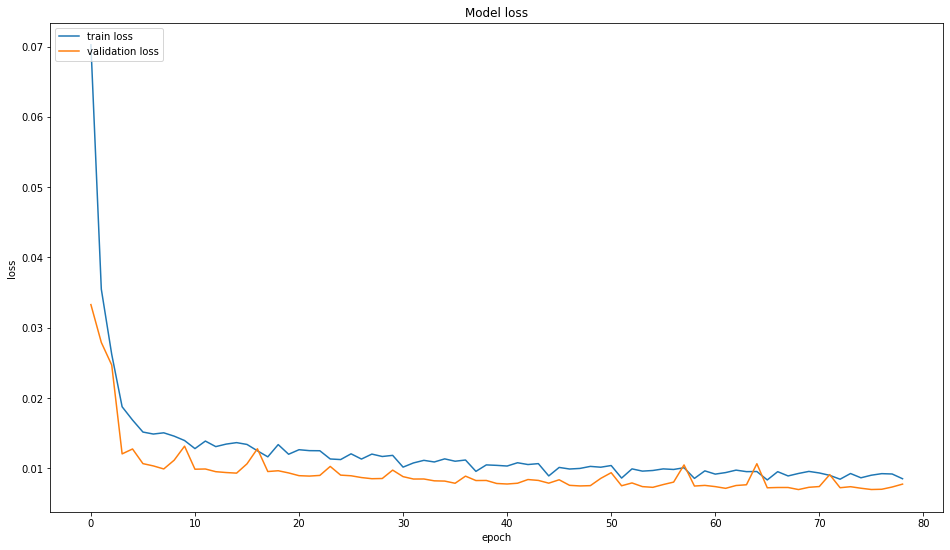

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [137]:
uni = df['traffic_volume']
validatehori = uni.tail(48)
validatehist = validatehori.values
result = []
# Define Forecast length here
window_len = 10
val_rescaled = scaler_x.fit_transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f'predicted : {Predicted_results}')
    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)


predicted : [[0.6664802]]
[0.80830343 0.77960021 0.83000171 0.94020161 1.         0.91576969
 0.81479583 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585
 0.23885187 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784
 0.17495302 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688
 0.73842474 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315
 0.72338971 0.51307022 0.44677943 0.388177   0.60157184 0.25474116
 0.09994874 0.06167777 0.00495472 0.         0.01862293 0.07978814
 0.14351615 0.28481121 0.43516146 0.5750897  0.63454639 0.66648018]
predicted : [[0.67511845]]
[0.77960021 0.83000171 0.94020161 1.         0.91576969 0.81479583
 0.67503844 0.54724073 0.46523151 0.40628737 0.54826585 0.23885187
 0.09089356 0.03229113 0.00410046 0.01537673 0.06970784 0.17495302
 0.29062019 0.46779429 0.57919016 0.63625491 0.69075688 0.73842474
 0.72065607 0.73176149 0.72253545 0.75175124 0.77618315 0.72338971
 0.51307022 0.44677943 0.388177   0.60157184 0.25474116 0.09994874
 0.06167

In [138]:
result_inv_trans = scaler_x.inverse_transform(result)

In [139]:
result_inv_trans

array([[4235.90851462],
       [4286.46826649],
       [4198.04260051],
       [4045.09277499],
       [3876.0522036 ],
       [3692.41856802],
       [3467.40279806],
       [3183.13737339],
       [2830.3494361 ],
       [2410.8878015 ]])

In [140]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [141]:
timeseries_evaluation_metrics_func(validate,result_inv_trans)

Evaluation metric results:-
MSE is : 569518.4022320593
MAE is : 539.3631616860628
RMSE is : 754.6644302152177
MAPE is : 62.643418764773706
R2 is : 0.6302600809174763



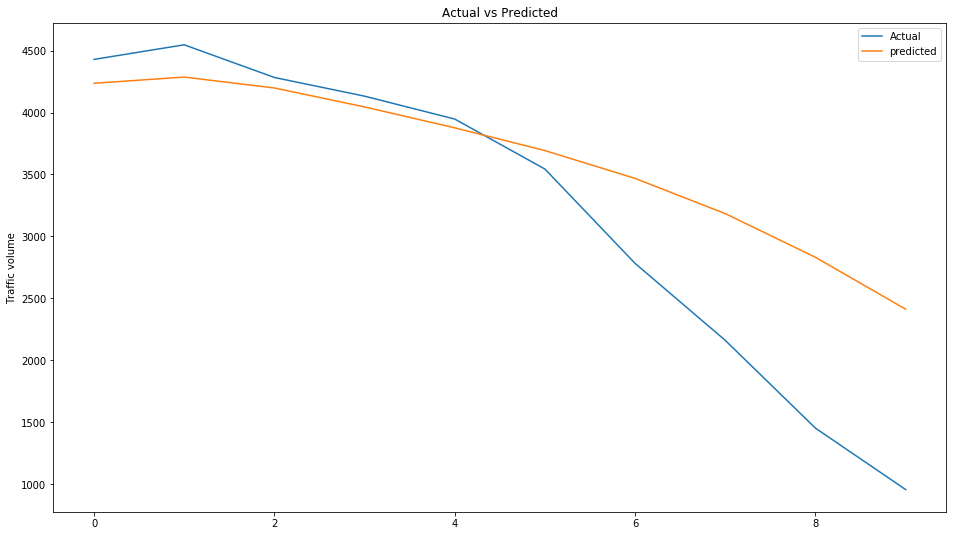

In [142]:
plt.plot( list(validate))
plt.plot( list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()